In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose

### Initialize dataset

In [53]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

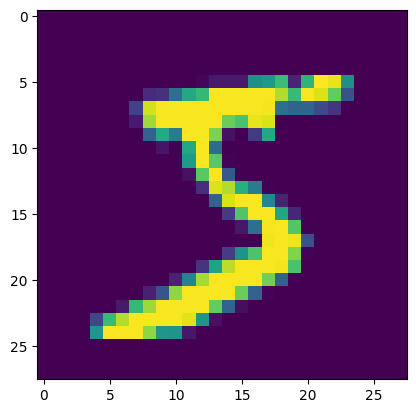

In [54]:
plt.imshow(X_train[0])

In [55]:
y_train[0]

5

In [56]:
y_train==0

array([False,  True, False, ..., False, False, False])

In [57]:
zeros = X_train[y_train == 0]
zeros.shape, X_train.shape

((5923, 28, 28), (60000, 28, 28))

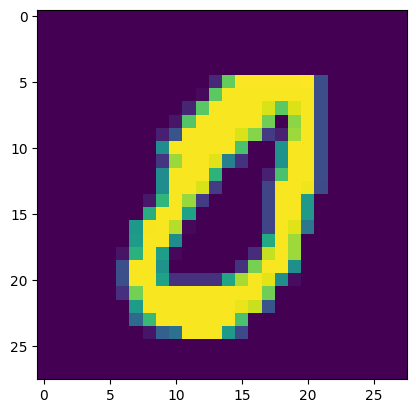

In [58]:
plt.imshow(zeros[10])

### Generator & Discriminator - Classic GAN

In [59]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28, 28]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')


In [60]:
# generator is basically just the decoder of an autoencoder
coding_size = 100

generator = Sequential()
generator.add(Dense(100, activation='relu', input_shape=[coding_size]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))
generator.add(Reshape([28, 28]))

In [61]:
GAN = Sequential([generator, discriminator])

In [62]:
discriminator.trainable = False

In [63]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

### Training Batches

In [64]:
batch_size = 32
data = zeros
epochs = 5

dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000)
type(dataset)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [65]:
print(data.shape)
print('remainder =', data.shape[0] % batch_size)

(5923, 28, 28)
remainder = 3


In [66]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [67]:
GAN.layers

In [68]:
GAN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 28, 28)            143634    
                                                                 
 sequential_6 (Sequential)   (None, 1)                 132951    
                                                                 
Total params: 276585 (1.06 MB)
Trainable params: 143634 (561.07 KB)
Non-trainable params: 132951 (519.34 KB)
_________________________________________________________________


In [69]:
generator, discriminator = GAN.layers

for epoch in range(epochs):generator, discriminator = GAN.layers

for epoch in range(epochs):
  print(f'Current Epoch {epoch+1}')
  i = 0

  for X_batch in dataset:
    i += 1
    if i % 100 == 0:
      print(f'Current Batch {i} of {len(data) // batch_size}')

    # Discriminator training phase
    noise = tf.random.normal(shape=[batch_size, coding_size])
    gen_images = generator(noise)
    X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
    y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)

    discriminator.trainable = True
    discriminator.train_on_batch(X_fake_vs_real, y1)

    # Generator training phase
    noise = tf.random.normal(shape=[batch_size, coding_size])
    y2 = tf.constant([[1.0]]*batch_size)

    discriminator.trainable = False
    GAN.train_on_batch(noise, y2)
  print(f'Current Epoch {epoch+1}')
  i = 0

  for X_batch in dataset:
    i += 1
    if i % 100 == 0:
      print(f'Current Batch {i} of {len(data) // batch_size}')

    # Discriminator training phase
    noise = tf.random.normal(shape=[batch_size, coding_size])
    gen_images = generator(noise)
    X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
    y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)

    discriminator.trainable = True
    discriminator.train_on_batch(X_fake_vs_real, y1)

    # Generator training phase
    noise = tf.random.normal(shape=[batch_size, coding_size])
    y2 = tf.constant([[1.0]]*batch_size)

    discriminator.trainable = False
    GAN.train_on_batch(noise, y2)

Current Epoch 1
Current Batch 100 of 185
Current Epoch 1
Current Batch 100 of 185
Current Epoch 2
Current Batch 100 of 185
Current Epoch 2
Current Batch 100 of 185
Current Epoch 3
Current Batch 100 of 185
Current Epoch 3
Current Batch 100 of 185
Current Epoch 4
Current Batch 100 of 185
Current Epoch 4
Current Batch 100 of 185
Current Epoch 5
Current Batch 100 of 185
Current Epoch 5
Current Batch 100 of 185


In [70]:
noise = tf.random.normal(shape=[10, coding_size])
noise.shape

TensorShape([10, 100])

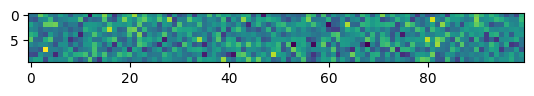

In [71]:
plt.imshow(noise)

In [72]:
images = generator(noise)
images.shape

TensorShape([10, 28, 28])

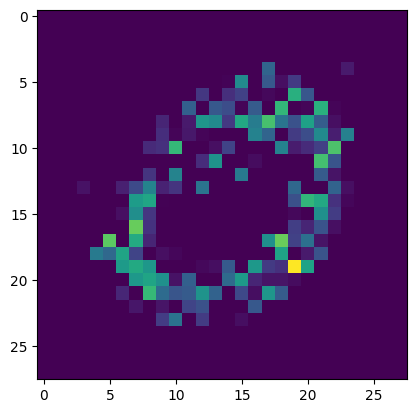

In [73]:
plt.imshow(images[0])

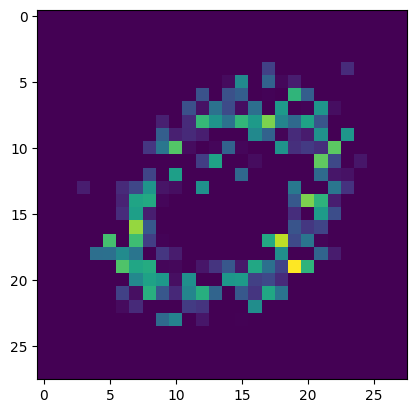

In [74]:
plt.imshow(images[1])

### Generator & Discriminator - DC GAN

**Reshape and Rescale images for DCGAN**

In [75]:
# Generator will use tanh activation func for the last layer,
# hence we have to reshape X_train to range(-1, 1).

X_train = X_train / 255
X_train = X_train.reshape(-1, 28, 28, 1) * 2 - 1

In [76]:
X_train.min(), X_train.max()

(-1.0, 1.0)

In [77]:
zeros = X_train[y_train == 0]
zeros.shape

(5923, 28, 28, 1)

In [78]:
np.random.seed(42)
tf.random.set_seed(42)
coding_size = 100

In [79]:
generator = Sequential()
generator.add(Dense(7*7*128, input_shape=[coding_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2,
                              padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2,
                              padding='same', activation='tanh'))

In [90]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same',
                         activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [91]:
GAN = Sequential([generator, discriminator])

In [92]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [93]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')
GAN.layers

In [94]:
GAN.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_12 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 840321 (3.21 MB)
Non-trainable params: 213249 (833.00 KB)
_________________________________________________________________


In [95]:
batch_size = 32
data = zeros
epochs = 30

dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000)
type(dataset)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [96]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [97]:
generator, discriminator = GAN.layers

for epoch in range(epochs):
  print(f'Current Epoch {epoch+1}')
  i = 0

  for X_batch in dataset:
    i += 1
    if i % 100 == 0:
      print(f'Current Batch {i} of {len(data) // batch_size}')

    # Discriminator training phase
    noise = tf.random.normal(shape=[batch_size, coding_size])
    gen_images = generator(noise)
    X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
    y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)

    discriminator.trainable = True
    discriminator.train_on_batch(X_fake_vs_real, y1)

    # Generator training phase
    noise = tf.random.normal(shape=[batch_size, coding_size])
    y2 = tf.constant([[1.0]]*batch_size)

    discriminator.trainable = False
    GAN.train_on_batch(noise, y2)

Current Epoch 1
Current Batch 100 of 185
Current Epoch 2
Current Batch 100 of 185
Current Epoch 3
Current Batch 100 of 185
Current Epoch 4
Current Batch 100 of 185
Current Epoch 5
Current Batch 100 of 185
Current Epoch 6
Current Batch 100 of 185
Current Epoch 7
Current Batch 100 of 185
Current Epoch 8
Current Batch 100 of 185
Current Epoch 9
Current Batch 100 of 185
Current Epoch 10
Current Batch 100 of 185
Current Epoch 11
Current Batch 100 of 185
Current Epoch 12
Current Batch 100 of 185
Current Epoch 13
Current Batch 100 of 185
Current Epoch 14
Current Batch 100 of 185
Current Epoch 15
Current Batch 100 of 185
Current Epoch 16
Current Batch 100 of 185
Current Epoch 17
Current Batch 100 of 185
Current Epoch 18
Current Batch 100 of 185
Current Epoch 19
Current Batch 100 of 185
Current Epoch 20
Current Batch 100 of 185
Current Epoch 21
Current Batch 100 of 185
Current Epoch 22
Current Batch 100 of 185
Current Epoch 23
Current Batch 100 of 185
Current Epoch 24
Current Batch 100 of 185
C

**NOTE**  
The generator never actually sees any real images. It learns by viewing the gradientsgoing back through the discriminator. The better the discriminator gets throught training, the more info the discriminator contains in its gradients, which means the generator can begin to make progress in learning how to generate fake images, in our case, fakse zeros.

Mode Collapse:  
hhtps://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same

In [98]:
noise = tf.random.normal(shape=[10, coding_size])
noise.shape

TensorShape([10, 100])

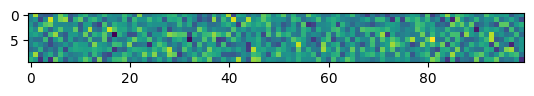

In [99]:
plt.imshow(noise)

In [100]:
images = generator(noise)

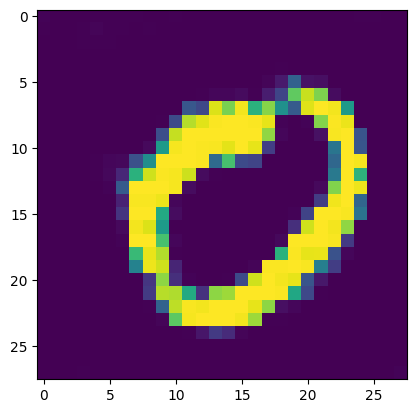

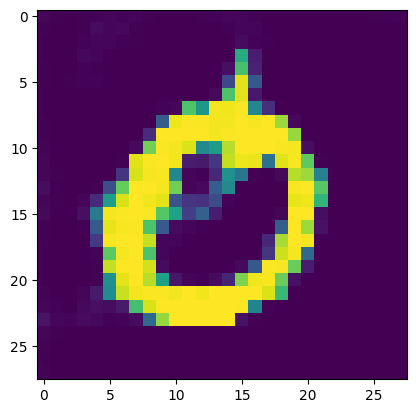

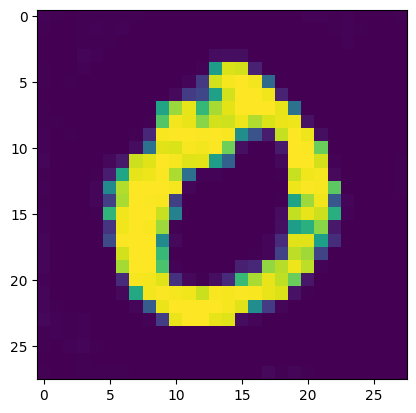

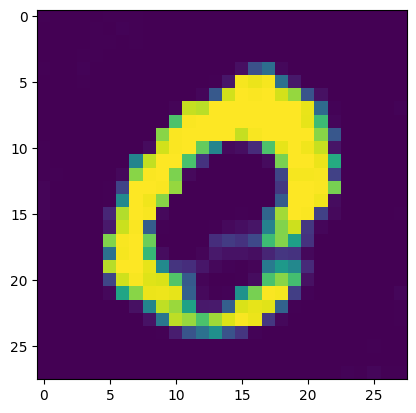

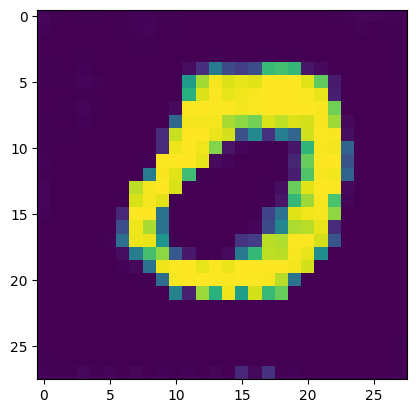

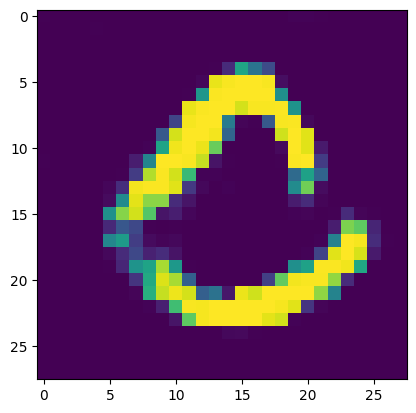

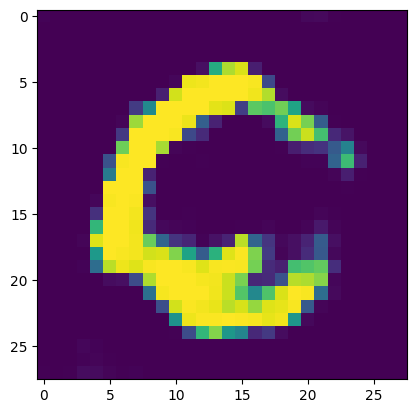

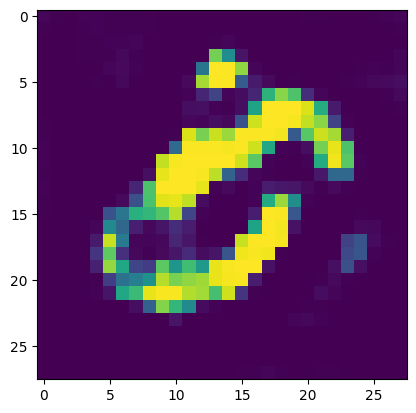

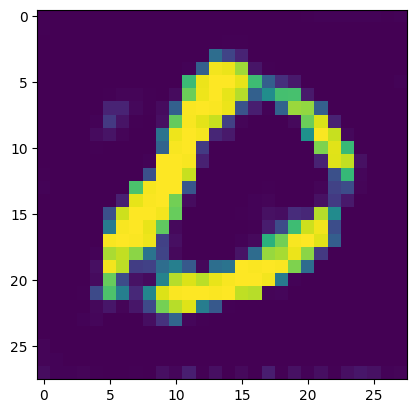

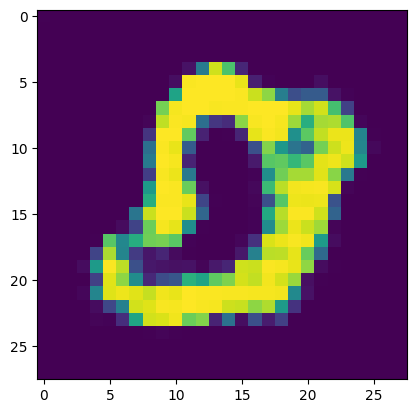

In [101]:
for image in images:
  plt.imshow(image.numpy().reshape(28, 28))
  plt.show()

**Observe the variation in generated images. Pretty sick, arent they?**   
**This is the courtesy of DCGAN - Deep Convolutional GAN**